# MERRA-2 Plotting with CMR HTTPS Cloud Access
### Author: Chris Battisto

### Timing

Exercise: 15 minutes

### Overview

This notebook demonstrates how to access and plot a single MERRA-2 file hosted via cloud services. It demonstrates how to use the CMR (Common Metadata Repository) API to find cloud-hosted MERRA-2 metadata, download a file locally through an HTTPS request, and then plot sea-level pressure data from that file. This notebook serves as an alternative method for accessing GES-DISC cloud data without their API, and is intended for users that wish to download single or multiple files without an Earthdata login.

### Prerequisites

This notebook was written using Python 3.8, and requires these libraries: *xarray, cartopy, matplotlib*.

## Import libraries

In [39]:
%matplotlib inline
#%pprint Turn pprint on/off
import os
import requests
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Search CMR catalogs, request data URLs

First, check that the CMR catalog can be accessed

In [4]:
url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request for finding cloud-hosted granules, and check that we can access CMR
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True', # 
                            'has_granules': 'True',
                        },
                        headers={
                            'Accept': 'application/json',
                        }
                       )

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible


In [5]:
# Check for hits in the GES_DISC CMR catalog

provider = 'GES_DISC'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider, # Only look for data hosted by GES-DISC
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )

# See how many hits are returned
response.headers['cmr-hits']


'1'

In [40]:
# See full JSON metadata, specifically links

response.json()['feed']['entry'][0]['links']

[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/browse#',
  'hreflang': 'en-US',
  'href': 'https://docserver.gesdisc.eosdis.nasa.gov/public/project/Images/M2T1NXSLV_5.12.4.png'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/documentation#',
  'hreflang': 'en-US',
  'href': 'https://disc.gsfc.nasa.gov/information/howto?tags=MERRA'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
  'hreflang': 'en-US',
  'href': 'https://disc.gsfc.nasa.gov/datacollection/M2T1NXSLV_5.12.4.html'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
  'hreflang': 'en-US',
  'href': 'https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/browse#',
  'hreflang': 'en-US',
  'href': 'https://giovanni.gsfc.nasa.gov/giovanni/#dataKeyword=M2T1NXSLV'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
  'hreflang': 'en-US',
  'href': 'https://search.earthdata.nasa.gov/search?q=M2T1NXSLV'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1

**NOTE**: None of these links use the data.gesdisc.earthdata.nasa.gov URL, which is where cloud data is located via the web-based CMR tool.

## Download with Python Requests

In [22]:
# Use the requests library to submit the HTTP_Services URLs and write out the results.
print('\nHTTP_services output:')

# File is ~400 MB big and may take a while to download
URL = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4'
result = requests.get(URL)
try:
    result.raise_for_status()
    outfn = URL[-39::]
    f = open(outfn,'wb')
    f.write(result.content)
    f.close()
except:
    print('Error! Status code is %d for this URL:\n%s' % (result.status.code,URL))
    print('Help for downloading data is at https://disc.gsfc.nasa.gov/data-access')


print('Downloading is done and find the downloaded files in your current working directory')


HTTP_services output:


## Plot CONUS sea-level pressure contours with Matplotlib/Cartopy

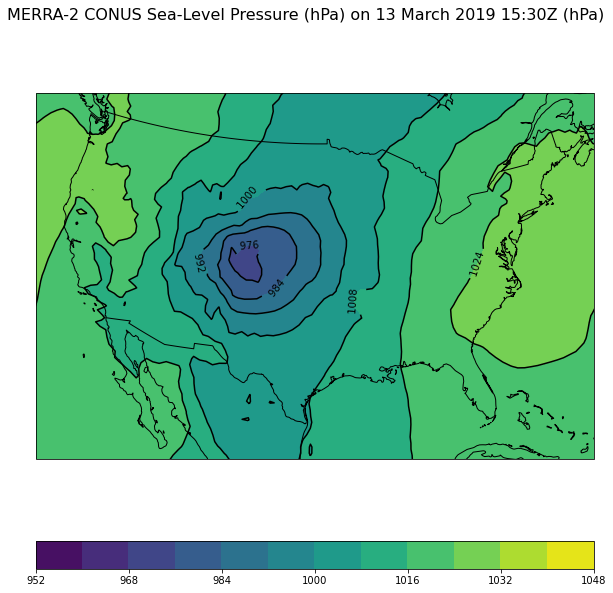

In [40]:
plt.rcParams['figure.figsize'] = 10,10

# Open up dataset, only select SLP at 15:30Z
ds = xr.open_dataset('MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4')
slp = ds.SLP.values[15,:,:] / 100 # convert to hPa

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  # Automatic placement vs manual placement.
    inline=True,  # Cut the line where the label will be placed.
    fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z (hPa)', fontsize=16)

plt.show()